In [1]:
import sys
import re
import time
import datetime
import pandas as pd
import numpy as np
import func
# inline plot
import matplotlib.pyplot as plt
%matplotlib inline

/Users/albarron/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
df = pd.read_csv("data/merged_concat_final.csv",sep='\t',error_bad_lines=False)
del df['Unnamed: 0']
print df.shape

(21021, 33)


In [5]:
df.set_index('timestamp')
df['timestamp'] = pd.to_datetime(df['timestamp'],format="%Y-%m-%d %H:%M:%S")

In [6]:
only_delay = df[(df['is_delay']==1)]

In [7]:
print "relative to delay"
print (df[['is_delay','del_min','del_med','del_maj','del_cat']].sum()/float(df['is_delay'].sum()))*100 , '%'
print "Relative to total"
print (df[['is_delay','del_min','del_med','del_maj','del_cat']].sum()/float(len(df)))*100 , '%'

relative to delay
is_delay    100.000000
del_min      27.828746
del_med      43.425076
del_maj       8.562691
del_cat       4.892966
dtype: float64 %
Relative to total
is_delay    1.555587
del_min     0.432900
del_med     0.675515
del_maj     0.133200
del_cat     0.076114
dtype: float64 %


In [8]:
# Train IDs swapped into cat variables and concat into main dataset
train_id_dummies = pd.get_dummies(df['train_id'],prefix='tid')
train_id_dummies.shape
train_id_dummies.columns.values
del train_id_dummies['tid_101.0'] # Delete as base var
tid_col = train_id_dummies.columns.values
df = pd.concat([df, train_id_dummies], axis=1)

### Pick one of these to explore re: below models

In [73]:
# Including train IDs
features = df.columns.values
target_cols = ['temp','precipiation',
        'visability','windspeed','humidity','cloudcover',
        'is_bullet','is_limited','t_northbound',
       'd_tuesday','d_wednesday','d_thursday','d_friday',] + list(tid_col)
X = df[target_cols]
# del X['is_delay']
# del X['tweet_id']
# X['timestamp'] = X['timestamp'].apply(lambda x: (np.datetime64(x).astype('uint64') / 1e6).astype('uint32'))
# y = df['ord_del']
y = df['is_delay']

In [74]:
# X['timestamp'] = X['timestamp'].apply(lambda x:int(x))
# X['stop_pa'] = X['stop_pa'].apply(lambda x:int(x))
# X['train_id'] = X['train_id'].apply(lambda x:int(x))
X['t_northbound'] = X['t_northbound'].apply(lambda x:int(x))
X['cloudcover'] = X['cloudcover'].fillna(X['cloudcover'].mean())

/Users/albarron/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/albarron/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Train/Test split

In [75]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25)

### Run Decision Trees, Prune, and consider False Positives

In [76]:
from sklearn.tree import DecisionTreeClassifier
TreeClass = DecisionTreeClassifier(
                max_depth = 2,
                min_samples_leaf = 5)
TreeClass.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')

In [77]:
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(TreeClass, X_test, y_test, cv=10)
print(scores.mean()) # Score = More is better, error is 1-score

0.99295925436


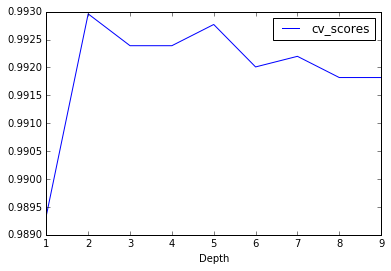

In [78]:
Depth = range(1,10)
score = []
for i in Depth:
      TreeClass = DecisionTreeClassifier(
                max_depth = i,
                min_samples_leaf = 5)
      scores = cross_val_score(TreeClass, X_test, y_test, cv=10)
      score.append(np.mean(scores))

Depth_Choice_df = pd.DataFrame({'cv_scores': score ,'Depth': Depth})
Depth_Choice_df.plot(x ='Depth',y = 'cv_scores' )

#It seems like at depth = 4 we achieved the best result

In [80]:
Depth_Choice_df.head()

,Depth,cv_scores
0,1,0.989345
1,2,0.992959
2,3,0.992389
3,4,0.992389
4,5,0.992769


In [97]:
TreeClass = DecisionTreeClassifier(
                max_depth = 2,
                min_samples_leaf = 5)
TreeClass.fit(X_train,y_train)
ImportanceDataFrame = pd.DataFrame({'feature':X.columns.values, 'Gini_Import':TreeClass.feature_importances_})
ImportanceDataFrame.sort_values(by = ['Gini_Import'],ascending = 0)

,Gini_Import,feature
7,0.686761,is_limited
6,0.305660,is_bullet
5,0.007579,cloudcover
0,0.000000,temp
66,0.000000,tid_267.0
76,0.000000,tid_283.0
75,0.000000,tid_282.0
74,0.000000,tid_279.0
73,0.000000,tid_278.0
72,0.000000,tid_277.0


In [94]:
df[['temp','precipiation','visability','windspeed','humidity','cloudcover']].corr()

,temp,precipiation,visability,windspeed,humidity,cloudcover
temp,1.000000,-0.209248,0.119720,0.333041,-0.345526,-0.158742
precipiation,-0.209248,1.000000,-0.459115,0.200260,0.303568,0.365534
visability,0.119720,-0.459115,1.000000,-0.119827,-0.427823,-0.343510
windspeed,0.333041,0.200260,-0.119827,1.000000,-0.004015,0.252678
humidity,-0.345526,0.303568,-0.427823,-0.004015,1.000000,0.487529
cloudcover,-0.158742,0.365534,-0.343510,0.252678,0.487529,1.000000


In [83]:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#example-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['No Delay','Delay'], rotation=45)
    plt.yticks(tick_marks, ['No Delay','Delay'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix:
[[20648    46]
 [  121   206]]
Normalized
[[ 0.9978  0.0022]
 [ 0.37    0.63  ]]


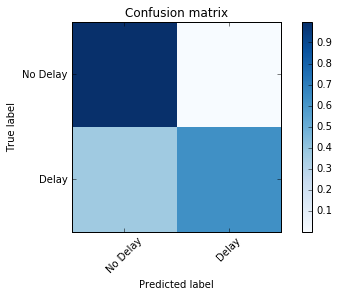

In [85]:
from sklearn.metrics import confusion_matrix
y_hat = TreeClass.predict(X)
cmat = confusion_matrix(y, y_hat)
c_norm = cmat.astype('float') / cmat.sum(axis=1)[:, np.newaxis]
print "Confusion matrix:"
print cmat
print "Normalized"
print np.round(c_norm,4)
plot_confusion_matrix(c_norm) # Normalized

In [86]:
print "Accuracy"
print np.round((cmat[1][1] + cmat[0][0]) / float(len(df)),4),'%'
print "Misclass"
print np.round((cmat[1][0] + cmat[0][1]) / float(len(df)),4),'%'
print "Sensitivity"
print np.round((cmat[1][1]) / float(cmat[1][1]+cmat[1][0]),4),'%'
print "Specificity"
print np.round((cmat[0][0]) / float(cmat[0][0]+cmat[0][1]),4),'%'

Accuracy
0.9921 %
Misclass
0.0079 %
Sensitivity
0.63 %
Specificity
0.9978 %


[ 0.00582599  0.00582599  0.00582599 ...,  0.00582599  0.00582599
  0.00582599]
0.813990833077


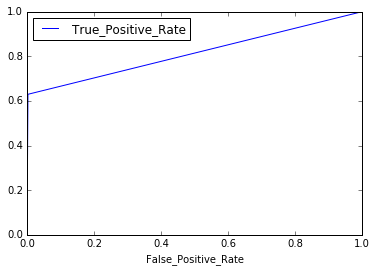

In [92]:
from sklearn.metrics import roc_curve, auc,roc_auc_score
TreeClass.fit(X,y)
y_hat_probability = TreeClass.predict_proba(X).T[1] 
print(y_hat_probability)
print(roc_auc_score(y, y_hat_probability))
vals = roc_curve(y, y_hat_probability)  
Roc_DataFrame = pd.DataFrame({'False_Positive_Rate':vals[0],'True_Positive_Rate':vals[1]})
Roc_DataFrame.plot(x = 'False_Positive_Rate' , y = 'True_Positive_Rate' ) 

### As a check, consider Feature selection

In [93]:
from sklearn import feature_selection
pvals = feature_selection.f_regression(X,y)[1] 
sorted(zip(X.columns.values,np.round(pvals,4)),key=lambda x:x[1],reverse=True)

[('tid_139.0', 0.82789999999999997),
 ('tid_221.0', 0.82789999999999997),
 ('tid_231.0', 0.82789999999999997),
 ('tid_257.0', 0.82789999999999997),
 ('tid_274.0', 0.82789999999999997),
 ('tid_370.0', 0.82789999999999997),
 ('tid_376.0', 0.82789999999999997),
 ('tid_147.0', 0.75109999999999999),
 ('tid_159.0', 0.75109999999999999),
 ('tid_197.0', 0.75109999999999999),
 ('tid_217.0', 0.75109999999999999),
 ('tid_220.0', 0.75109999999999999),
 ('tid_227.0', 0.75109999999999999),
 ('tid_264.0', 0.75109999999999999),
 ('tid_279.0', 0.75109999999999999),
 ('tid_284.0', 0.75109999999999999),
 ('tid_287.0', 0.75109999999999999),
 ('tid_366.0', 0.75109999999999999),
 ('tid_380.0', 0.75109999999999999),
 ('tid_385.0', 0.75109999999999999),
 ('tid_386.0', 0.75109999999999999),
 ('tid_138.0', 0.4521),
 ('tid_258.0', 0.4521),
 ('tid_267.0', 0.4521),
 ('tid_277.0', 0.4521),
 ('tid_278.0', 0.4521),
 ('tid_283.0', 0.4521),
 ('tid_323.0', 0.4521),
 ('tid_134.0', 0.39429999999999998),
 ('tid_193.0', 0.3

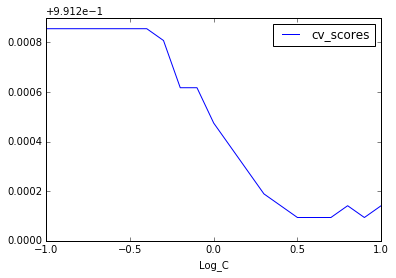

In [60]:
from sklearn.linear_model import LogisticRegression
lm = LogisticRegression()
lm.fit(X,y)
X_lr=df[['windspeed','t_northbound','precipiation','d_friday']]
# localize your search around the maximum value you found
c_list = np.logspace(-1,1,21) 
c_index = np.linspace(-1,1,21)
#C is just the inverse of Lambda - the smaller the C - the stronger the
#regulatization. The smaller C's choose less variables
cv_scores = []
for c_score in c_list:
    lm = LogisticRegression(C = c_score, penalty = "l1")
    cv_scores.append(cross_val_score(lm,X,y,cv=10).mean())


C_Choice_df = pd.DataFrame({'cv_scores': cv_scores ,'Log_C': c_index })
C_Choice_df.plot(x ='Log_C',y = 'cv_scores' )
# it sounds like our best choice is C = -0.1  (we chose the most restrictive option)

In [100]:
X.head()

,temp,precipiation,visability,windspeed,humidity,cloudcover,is_bullet,is_limited,t_northbound,d_tuesday,...,tid_365.0,tid_366.0,tid_370.0,tid_371.0,tid_375.0,tid_376.0,tid_380.0,tid_381.0,tid_385.0,tid_386.0
0,72.97875,0,10,6.68125,0.62875,0.09875,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,72.97875,0,10,6.68125,0.62875,0.09875,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,72.97875,0,10,6.68125,0.62875,0.09875,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,72.97875,0,10,6.68125,0.62875,0.09875,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,72.97875,0,10,6.68125,0.62875,0.09875,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Run for Boosting

In [195]:
from sklearn.ensemble import GradientBoostingClassifier
GBC_Tree = GradientBoostingClassifier(learning_rate = 0.01,
                                      n_estimators = 10000,
                                      max_depth = 2,
                                      min_samples_leaf = 5)
 

from sklearn import cross_validation
kf = cross_validation.KFold(len(df), n_folds = 10, shuffle = True) #10 fold CV
scores = []
for train_index, test_index in kf:        
        GBC_Tree.fit(X.iloc[train_index], y.iloc[train_index])
        y_hat_test = GBC_Tree.predict(X.iloc[test_index]) 
        scores.append(float(sum(y_hat_test == y.iloc[test_index]))/len(y_hat_test))

Score_GBC_CV = np.mean(scores)    

print(Score_GBC_CV)

0.991484888834


Confusion matrix:
[[20666    28]
 [  111   216]]
Normalized
[[ 0.9986  0.0014]
 [ 0.3394  0.6606]]


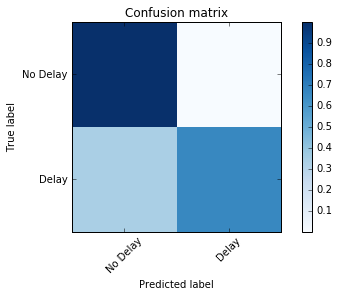

In [196]:
from sklearn.metrics import confusion_matrix
y_hat = GBC_Tree.predict(X)
cmat = confusion_matrix(y, y_hat)
c_norm = cmat.astype('float') / cmat.sum(axis=1)[:, np.newaxis]
print "Confusion matrix:"
print cmat
print "Normalized"
print np.round(c_norm,4)
plot_confusion_matrix(c_norm) # Normalized

In [197]:
print "Accuracy"
print np.round((cmat[1][1] + cmat[0][0]) / float(len(df)),4),'%'
print "Misclass"
print np.round((cmat[1][0] + cmat[0][1]) / float(len(df)),4),'%'
print "Sensitivity"
print np.round((cmat[1][1]) / float(cmat[1][1]+cmat[1][0]),4),'%'
print "Specificity"
print np.round((cmat[0][0]) / float(cmat[0][0]+cmat[0][1]),4),'%'

Accuracy
0.9934 %
Misclass
0.0066 %
Sensitivity
0.6606 %
Specificity
0.9986 %


### Prediction Prototype

In [202]:
import forecastio
keys = pd.read_csv('keys.csv') # hidden from github
forecaseiokey=keys.iloc[5].string
api_key = forecaseiokey
lat = 37.441879
lng = -122.143021
time = datetime.datetime.now()
forecast = forecastio.load_forecast(api_key, lat, lng,time=time)
current = forecast.currently()

In [204]:
print current.d

{u'ozone': 364.43, u'temperature': 64.79, u'icon': u'clear-day', u'dewPoint': 49.88, u'humidity': 0.58, u'visibility': 9.92, u'summary': u'Clear', u'apparentTemperature': 64.79, u'pressure': 1015.48, u'windSpeed': 6.9, u'cloudCover': 0.12, u'time': 1459377043, u'windBearing': 321, u'precipIntensity': 0, u'precipProbability': 0}


In [207]:
The_train = '371'
Predict_me = pd.DataFrame({
        'temp': [current.d['apparentTemperature']],
        'precipiation': [current.d['precipIntensity']],
        'visability': [current.d['visibility']],
        'windspeed': [current.d['windSpeed']],
        'humidity': [current.d['humidity']],
        'cloudcover': [current.d['cloudCover']],
        'is_bullet':[1],
        'is_limited':[0],
        't_northbound':[1],
        'd_tuesday': 1 if time.weekday == 1 else 0,
        'd_wednesday':1 if time.weekday == 2 else 0,
        'd_thursday':1 if time.weekday == 3 else 0,
        'd_friday':1 if time.weekday == 4 else 0
        })


t = pd.DataFrame(columns=tid_col)
t = t.append([0]).fillna(0)
t['tid_'+The_train+'.0'] = 1
t['tid_'+The_train+'.0']
Predict_me = pd.concat([Predict_me, t],axis=1)
del Predict_me[0]
pred = GBC_Tree.predict(Predict_me)[0]
pprob = GBC_Tree.predict_proba(Predict_me)
print "Will be delayed:",pred
print "Probability:",np.round(pprob[0][0],4)*100,'%'

Will be delayed: 1
Probability: 0.11 %
